# Building Award-Specific Modeling Datasets

This notebook derives **award-specific datasets** from a shared feature space.

Using:
- `df_clean` for eligibility rules and target construction,
- `X_df_era` / `X_df_modern` for model-ready features,

we create clean, time-aware datasets for each NBA award.

Each award dataset includes:
- an explicitly defined eligible player population,
- a binary winner target,
- consistent train / validation / test splits by season.

Feature definitions are **not modified** in this notebook.
All award logic is applied on top of a fixed, leakage-safe feature space,
ensuring comparability across models and awards.


In [46]:
from pathlib import Path
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# Project root (robust, no pyproject.toml needed)
# Looks for common "project markers": .git, data/, notebooks/, README.md
# ------------------------------------------------------------------

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR

MARKERS = [
    ".git",
    "data",
    "notebooks",
    "README.md",
]

def is_project_root(p: Path) -> bool:
    return any((p / m).exists() for m in MARKERS)

while not is_project_root(PROJECT_ROOT):
    if PROJECT_ROOT.parent == PROJECT_ROOT:
        raise RuntimeError(
            "Project root not found. Run this notebook from inside the repo "
            "(a folder containing one of: .git, data/, notebooks/, README.md)."
        )
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED_FINAL = DATA_PROCESSED / "players" / "final"
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
DATA_INTERIM.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)


PROJECT_ROOT: c:\Users\Luc\Documents\projets-data\nba-awards-predictor
DATA_PROCESSED: c:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\processed


In [47]:
# Load artifacts
df_clean = pd.read_parquet(DATA_INTERIM / "df_clean.parquet")
X_df_era = pd.read_parquet(DATA_INTERIM / "X_df_era.parquet")
X_df_modern = pd.read_parquet(DATA_INTERIM / "X_df_modern.parquet")

print("df_clean:", df_clean.shape)
print("X_df_era:", X_df_era.shape)
print("X_df_modern:", X_df_modern.shape)


df_clean: (13842, 427)
X_df_era: (13842, 145)
X_df_modern: (13842, 145)


## Helpers


In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def time_split_masks(
    df: pd.DataFrame,
    season_col: str = "season",
    train_end: int = 2018,
    val_end: int = 2021,
):
    """
    Time-aware split masks (award-local):
      - Train: season <= train_end
      - Val:   train_end < season <= val_end
      - Test:  season > val_end
    """
    train_mask = df[season_col] <= train_end
    val_mask   = (df[season_col] > train_end) & (df[season_col] <= val_end)
    test_mask  = df[season_col] > val_end
    return train_mask, val_mask, test_mask


def sanity_label_by_split(y: pd.Series, seasons: pd.Series, train_mask: pd.Series, val_mask: pd.Series, test_mask: pd.Series, title: str):
    """Basic sanity checks for extreme-imbalance award labels.

    Prints:
    - class distribution per split (count + ratio)
    - season span per split
    - winners-per-season stats (should be ~1 for most awards)
    Also plots the positive rate for a quick visual check.
    """
    print(f"=== {title} label distribution by split ===")
    for name, mask in [("Train", train_mask), ("Validation", val_mask), ("Test", test_mask)]:
        yy = y.loc[mask]
        vc = yy.value_counts().sort_index()
        total = len(yy)

        out = pd.DataFrame({
            "count": vc,
            "ratio": (vc / total).round(6),
        })
        display(out)

        smin, smax = int(seasons.loc[mask].min()), int(seasons.loc[mask].max())
        print(f"Seasons: {smin} → {smax}")

        winners = yy.groupby(seasons.loc[mask]).sum()
        print(
            f"{name} - winners per season (min/median/max):",
            int(winners.min()),
            float(winners.median()),
            int(winners.max()),
        )
        print()

    rates = [y.loc[train_mask].mean(), y.loc[val_mask].mean(), y.loc[test_mask].mean()]
    plt.figure()
    plt.bar(["Train", "Val", "Test"], rates)
    plt.title(f"{title} positive rate by split")
    plt.ylabel("Winner rate")
    plt.show()


def build_award_dataset(
    df_clean: pd.DataFrame,
    X_df: pd.DataFrame,
    eligibility_mask: pd.Series,
    target_col: str,
):
    """
    Build award dataset:
      - filters df_clean by eligibility_mask
      - builds y from target_col (int8)
      - aligns X from X_df using the filtered df index
    """
    eligibility_mask = eligibility_mask.reindex(df_clean.index).fillna(False)

    df_aw = df_clean.loc[eligibility_mask].copy()
    if target_col not in df_aw.columns:
        raise KeyError(f"Missing target column in df_clean: {target_col}")

    # safe conversion: treat missing as 0 (non-winner)
    y = df_aw[target_col].fillna(0).astype("int8")

    X = X_df.loc[df_aw.index].copy()
    assert len(X) == len(y), "X/y length mismatch after index alignment"
    return df_aw, X, y


## Rookie of the Year (ROY)

Eligibility: `is_rookie == 1`.
Target: `is_roy_winner`.


ROY population shape: (2318, 427)
Unique seasons (ROY): 1996 → 2024


is_roy_winner
non-winner    2288
winner          30
Name: count, dtype: int64

=== ROY label distribution by split ===


,count,ratio
is_roy_winner,,
0,1665,0.98579
1,24,0.01421


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 2



,count,ratio
is_roy_winner,,
0,314,0.990536
1,3,0.009464


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_roy_winner,,
0,309,0.990385
1,3,0.009615


Seasons: 2022 → 2024
Test - winners per season (min/median/max): 1 1.0 1



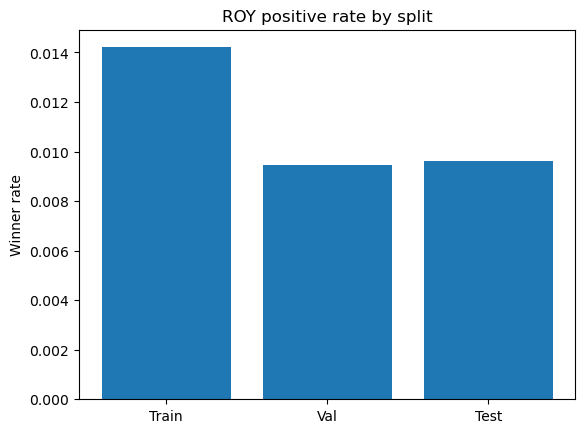

In [49]:
roy_mask = df_clean["is_rookie"].eq(1)

roy_df, X_roy, y_roy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=roy_mask,
    target_col="is_roy_winner",
)

print("ROY population shape:", roy_df.shape)
print("Unique seasons (ROY):", int(roy_df["season"].min()), "→", int(roy_df["season"].max()))
display(y_roy.value_counts().rename({0:"non-winner", 1:"winner"}))

train_mask, val_mask, test_mask = time_split_masks(roy_df)
sanity_label_by_split(
    y_roy,
    roy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "ROY",
)


## Sixth Man of the Year (SMOY)

Eligibility: player must come off the bench more often than he starts.

We approximate this with `GS <= G - GS` (bench games ≥ starts).
Target: `is_smoy_winner`.


SMOY population shape: (8961, 427)
Unique seasons (SMOY): 1996 → 2024


is_smoy_winner
non-winner    8932
winner          29
Name: count, dtype: int64

GS <= G-GS rate: 0.6473775465973125
Bench share (min/median/max): 0.0 0.7941176470588235 1.0
=== SMOY label distribution by split ===


,count,ratio
is_smoy_winner,,
0,6686,0.996572
1,23,0.003428


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_smoy_winner,,
0,1062,0.997183
1,3,0.002817


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_smoy_winner,,
0,1184,0.997473
1,3,0.002527


Seasons: 2022 → 2024
Test - winners per season (min/median/max): 1 1.0 1



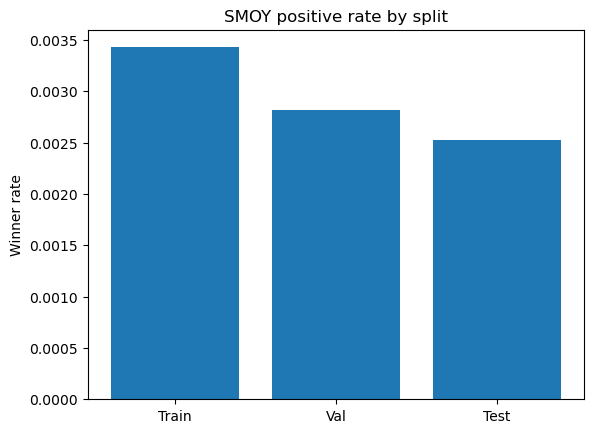

In [50]:
# Eligibility: bench games >= starts
G = df_clean["G"]
GS = df_clean["GS"]
smoy_mask = (GS <= (G - GS))

smoy_df, X_smoy, y_smoy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=smoy_mask,
    target_col="is_smoy_winner",
)

print("SMOY population shape:", smoy_df.shape)
print("Unique seasons (SMOY):", int(smoy_df["season"].min()), "→", int(smoy_df["season"].max()))
display(y_smoy.value_counts().rename({0:"non-winner", 1:"winner"}))

# eligibility sanity
bench_share = (G - GS) / G.replace(0, np.nan)
print("GS <= G-GS rate:", float(smoy_mask.mean()))
print("Bench share (min/median/max):", float(bench_share.min()), float(bench_share.median()), float(bench_share.max()))

train_mask, val_mask, test_mask = time_split_masks(smoy_df)
sanity_label_by_split(
    y_smoy,
    smoy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "SMOY",
)


## Defensive Player of the Year (DPOY)

No strict eligibility filter.
Target: `is_dpoy_winner`.


=== DPOY label distribution by split ===


,count,ratio
is_dpoy_winner,,
0,10504,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_dpoy_winner,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_dpoy_winner,,
0,1713,0.998252
1,3,0.001748


Seasons: 2022 → 2024
Test - winners per season (min/median/max): 1 1.0 1



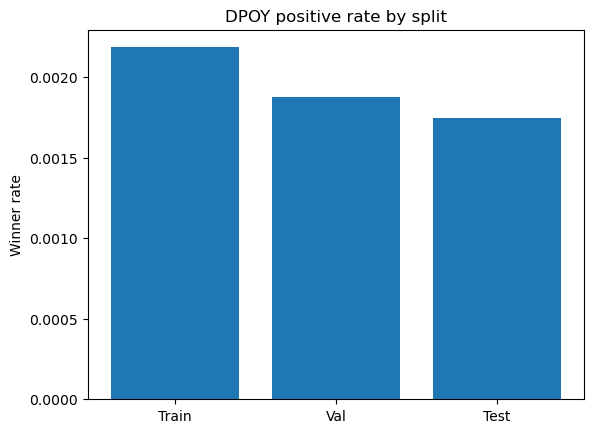

In [51]:
dpoy_mask = pd.Series(True, index=df_clean.index)

dpoy_df, X_dpoy, y_dpoy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=dpoy_mask,
    target_col="is_dpoy_winner",
)

train_mask, val_mask, test_mask = time_split_masks(dpoy_df)
sanity_label_by_split(
    y_dpoy,
    dpoy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "DPOY",
)

## Most Valuable Player (MVP)

No strict eligibility filter.
Target: `is_mvp_winner`.


=== MVP label distribution by split ===


,count,ratio
is_mvp_winner,,
0,10504,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_mvp_winner,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_mvp_winner,,
0,1713,0.998252
1,3,0.001748


Seasons: 2022 → 2024
Test - winners per season (min/median/max): 1 1.0 1



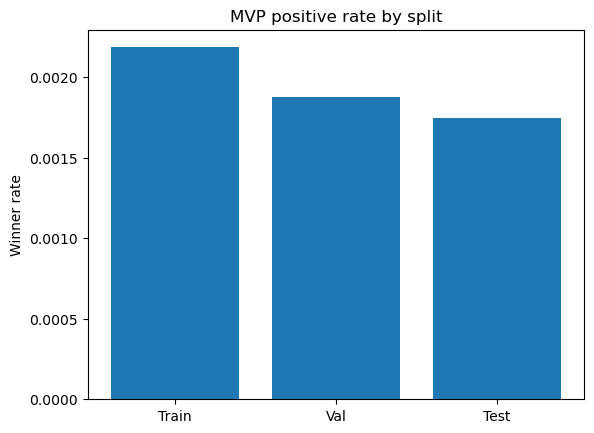

In [52]:
mvp_mask = pd.Series(True, index=df_clean.index)

mvp_df, X_mvp, y_mvp = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=mvp_mask,
    target_col="is_mvp_winner",
)

train_mask, val_mask, test_mask = time_split_masks(mvp_df)
sanity_label_by_split(
    y_mvp,
    mvp_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "MVP",
)

## Next: MIP, etc.

MIP requires *year-over-year deltas* and therefore lives in the modeling notebook where we engineer lagged features safely.
